## Requirements

* Local NVIDIA GPU or Google Colab(I used a T4GPU on a colab)  with access to a GPU.
* Data source (for example, a PDF).
* Internet connection (to download the models, but once you have them, it'll run offline).

In [1]:
import os

if "COLAB_GPU" in os.environ:
    print("[INFO] Running in Google Colab, installing requirements.")
    !pip install -U torch
    !pip install PyMuPDF
    !pip install tqdm
    !pip install sentence-transformers
    !pip install accelerate
    !pip install bitsandbytes
    !pip install flash-attn --no-build-isolation

[INFO] Running in Google Colab, installing requirements.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 899.7/899.7 MB 752.4 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 594.3/594.3 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 81.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 MB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 954.8/954.8 kB 70.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.1/193.1 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 51.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.6/63.6 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.5/267.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.2/288.2 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.3/39.3 MB 22.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.0/90.0 kB 8.9 MB/s eta

## 1. Document/Text Processing and Embedding Creation

Steps:
1. Import PDF docs.
2. Process text for embedding (split into chunks of sentences).
3. Embed text chunks with embedding model.
4. Save embeddings to a csv file.

In [41]:
# Download PDF file
import os
import requests

pdf_path = "alice.pdf"

if not os.path.exists(pdf_path):
  print("File doesn't exist, downloading...")

  url = "https://www.stgregoriosudaipur.ac.in/pdf/fiction/Alice%27s-Adventures-in-Wonderland.pdf"

  filename = pdf_path

  response = requests.get(url)

  if response.status_code == 200:
      with open(filename, "wb") as file:
          file.write(response.content)
      print(f"The file has been downloaded and saved as {filename}")
  else:
      print(f"Failed to download the file. Status code: {response.status_code}")
else:
  print(f"File {pdf_path} exists.")

File doesn't exist, downloading...
The file has been downloaded and saved as alice.pdf


In [42]:
import fitz
from tqdm.auto import tqdm

def text_formatter(text: str) -> str:
    """Performs minor formatting on text."""
    cleaned_text = text.replace("\n", " ").strip()
    return cleaned_text
def open_and_read_pdf(pdf_path: str) -> list[dict]:
    doc = fitz.open(pdf_path) open a document
    pages_and_texts = []
    for page_number, page in tqdm(enumerate(doc)):
        text = page.get_text()
        text = text_formatter(text)
        pages_and_texts.append({"page_number": page_number - 7,
                                "page_char_count": len(text),
                                "page_word_count": len(text.split(" ")),
                                "page_sentence_count_raw": len(text.split(". ")),
                                "page_token_count": len(text) / 4,
                                "text": text})
    return pages_and_texts

pages_and_texts = open_and_read_pdf(pdf_path=pdf_path)
pages_and_texts[30:32]

0it [00:00, ?it/s]

[{'page_number': 23,
  'page_char_count': 1590,
  'page_word_count': 279,
  'page_sentence_count_raw': 10,
  'page_token_count': 397.5,
  'text': 'CHAPTER V Advice from a Caterpillar T HE Caterpillar and Alice looked at each other for some time in silence: at last the Caterpillar took the hookah out of its mouth, and addressed her in a languid, sleepy voice. "Who are you?" said the Caterpillar. This was not an encouraging opening for a conversation. Alice replied, rather shyly, "I hardly know, sir, just at present—at least I know who I was when I got up this morning, but I think I must have been changed several times since then." "What do you mean by that?" said the Caterpillar sternly. "Explain yourself!" "I can\'t explain myself, I\'m afraid, sir," said Alice, "because I\'m not myself, you see." "I don\'t see," said the Caterpillar. "I\'m afraid I can\'t put it more clearly," Alice replied very politely, "for I can\'t understand it myself to begin with; and being so many different si

Now let's get a random sample of the pages.

In [43]:
import random

random.sample(pages_and_texts, k=3)

[{'page_number': -5,
  'page_char_count': 611,
  'page_word_count': 102,
  'page_sentence_count_raw': 3,
  'page_token_count': 152.75,
  'text': 'ALICE\'S ADVENTURES IN WONDERLAND "Alice" Title page PRINTED IN ENGLAND \'Tis two score years since CARROLL\'S art, With topsy-turvy magic, Sent ALICE wondering through a part Half-comic and half-tragic. Enchanting ALICE! Black-and-white Has made your deeds perennial; And naught save "Chaos and old Night" Can part you now from TENNIEL; But still you are a Type, and based In Truth, like LEAR and HAMLET; And Types may be re-draped to taste In cloth-of-gold or camlet. Here comes afresh Costumier, then; That Taste may gain a wrinkle From him who drew with such deft pen The rags of RIP VAN WINKLE! AUSTIN DOBSON.'},
 {'page_number': 84,
  'page_char_count': 3496,
  'page_word_count': 649,
  'page_sentence_count_raw': 21,
  'page_token_count': 874.0,
  'text': 'Project Gutenberg-tm trademark as set forth in paragraphs 1.E.8 or 1.E.9. 1.E.3.  If an i

In [44]:
import pandas as pd

df = pd.DataFrame(pages_and_texts)
df.head()

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,text
0,-7,0,1,1,0.00,
1,-6,1207,191,6,301.75,Project Gutenberg's Alice's Adventures in Wond...
2,-5,611,102,3,152.75,"ALICE'S ADVENTURES IN WONDERLAND ""Alice"" Title..."
3,-4,960,174,6,240.00,All in the golden afternoon Full leisurely we ...
4,-3,310,55,2,77.50,Its quaint events were hammered out— And now t...


In [45]:
# Get stats
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count
count,95.00,95.00,95.00,95.00,95.00
mean,40.00,1758.52,322.69,10.51,439.63
std,27.57,683.41,123.71,5.14,170.85
min,-7.00,0.00,1.00,1.00,0.00
25%,16.50,1524.00,275.50,7.00,381.00
50%,40.00,1798.00,330.00,11.00,449.50
75%,63.50,2100.00,386.50,13.00,525.00
max,87.00,3815.00,649.00,26.00,953.75


### Further text processing (splitting pages into sentences)



As in, chunk a page of text into groups of 5, 7, 10 or more sentences (10 in this case).


In [46]:
from spacy.lang.en import English
nlp = English()

nlp.add_pipe("sentencizer")

doc = nlp("This is a sentence. This another sentence.")
assert len(list(doc.sents)) == 2

list(doc.sents)

[This is a sentence., This another sentence.]

In [47]:
for item in tqdm(pages_and_texts):
    item["sentences"] = list(nlp(item["text"]).sents)

    # Make sure all sentences are strings
    item["sentences"] = [str(sentence) for sentence in item["sentences"]]

    # Count the sentences
    item["page_sentence_count_spacy"] = len(item["sentences"])

  0%|          | 0/95 [00:00<?, ?it/s]

In [48]:
# Inspect an example
random.sample(pages_and_texts, k=1)

[{'page_number': 66,
  'page_char_count': 1438,
  'page_word_count': 266,
  'page_sentence_count_raw': 7,
  'page_token_count': 359.5,
  'text': '"Well, I never heard it before," said the Mock Turtle: "but it sounds uncommon nonsense." Alice said nothing; she had sat down with her face in her hands, wondering if anything would ever happen in a natural way again. "I should like to have it explained," said the Mock Turtle. "She ca\'n\'t explain it," hastily said the Gryphon. "Go on with the next verse." "But about his toes?" the Mock Turtle persisted. "How could he turn them out with his nose, you know?" "It\'s the first position in dancing," Alice said; but was dreadfully puzzled by the whole thing, and longed to change the subject. "Go on with the next verse," the Gryphon repeated: "it begins \'I passed by his garden.\'" Alice did not dare to disobey, though she felt sure it would all come wrong, and she went on in a trembling voice: "I passed by his garden, and marked, with one eye, H

In [49]:
df = pd.DataFrame(pages_and_texts)
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,page_sentence_count_spacy
count,95.00,95.00,95.00,95.00,95.00,95.00
mean,40.00,1758.52,322.69,10.51,439.63,19.37
std,27.57,683.41,123.71,5.14,170.85,7.96
min,-7.00,0.00,1.00,1.00,0.00,0.00
25%,16.50,1524.00,275.50,7.00,381.00,14.00
50%,40.00,1798.00,330.00,11.00,449.50,21.00
75%,63.50,2100.00,386.50,13.00,525.00,25.00
max,87.00,3815.00,649.00,26.00,953.75,35.00


### Chunking our sentences together

This step is to break down our list of sentences/text into smaller chunks.


So our groups of 10 sentences will also be ~287 tokens long.

The `all-mpnet-base-v2` model has a capacity of 384 tokens.


In [50]:
num_sentence_chunk_size = 10

def split_list(input_list: list,
               slice_size: int) -> list[list[str]]:
    """
    Splits the input_list into sublists of size slice_size (or as close as possible).

    For example, a list of 17 sentences would be split into two lists of [[10], [7]]
    """
    return [input_list[i:i + slice_size] for i in range(0, len(input_list), slice_size)]

for item in tqdm(pages_and_texts):
    item["sentence_chunks"] = split_list(input_list=item["sentences"],
                                         slice_size=num_sentence_chunk_size)
    item["num_chunks"] = len(item["sentence_chunks"])

  0%|          | 0/95 [00:00<?, ?it/s]

In [51]:
random.sample(pages_and_texts, k=1)

[{'page_number': 62,
  'page_char_count': 1591,
  'page_word_count': 292,
  'page_sentence_count_raw': 11,
  'page_token_count': 397.75,
  'text': '"Back to land again, and—that\'s all the first figure," said the Mock Turtle, suddenly dropping his voice; and the two creatures, who had been jumping about like mad things all this time, sat down again very sadly and quietly, and looked at Alice. "It must be a very pretty dance," said Alice, timidly. "Would you like to see a little of it?" said the Mock Turtle. "Very much indeed," said Alice. "Come, let\'s try the first figure!" said the Mock Turtle to the Gryphon. "We can do it without lobsters, you know. Which shall sing?" "Oh, you sing," said the Gryphon. "I\'ve forgotten the words." So they began solemnly dancing round and round Alice, every now and then treading on her toes when they passed too close, and waving their forepaws to mark the time, while the Mock Turtle sang this, very slowly and sadly:— "Will you walk a little faster?" s

In [52]:
df = pd.DataFrame(pages_and_texts)
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,page_sentence_count_spacy,num_chunks
count,95.00,95.00,95.00,95.00,95.00,95.00,95.00
mean,40.00,1758.52,322.69,10.51,439.63,19.37,2.41
std,27.57,683.41,123.71,5.14,170.85,7.96,0.83
min,-7.00,0.00,1.00,1.00,0.00,0.00,0.00
25%,16.50,1524.00,275.50,7.00,381.00,14.00,2.00
50%,40.00,1798.00,330.00,11.00,449.50,21.00,3.00
75%,63.50,2100.00,386.50,13.00,525.00,25.00,3.00
max,87.00,3815.00,649.00,26.00,953.75,35.00,4.00


### Splitting each chunk into its own item

Embed each chunk of sentences into its own numerical representation.


In [53]:
import re

pages_and_chunks = []
for item in tqdm(pages_and_texts):
    for sentence_chunk in item["sentence_chunks"]:
        chunk_dict = {}
        chunk_dict["page_number"] = item["page_number"]

        joined_sentence_chunk = "".join(sentence_chunk).replace("  ", " ").strip()
        joined_sentence_chunk = re.sub(r'\.([A-Z])', r'. \1', joined_sentence_chunk) # ".A" -> ". A" for any full-stop/capital letter combo
        chunk_dict["sentence_chunk"] = joined_sentence_chunk

        chunk_dict["chunk_char_count"] = len(joined_sentence_chunk)
        chunk_dict["chunk_word_count"] = len([word for word in joined_sentence_chunk.split(" ")])
        chunk_dict["chunk_token_count"] = len(joined_sentence_chunk) / 4 # 1 token = ~4 characters

        pages_and_chunks.append(chunk_dict)

len(pages_and_chunks)

  0%|          | 0/95 [00:00<?, ?it/s]

229

In [54]:
len(pages_and_chunks)


229

In [55]:
random.sample(pages_and_chunks, k=3)

[{'page_number': 41,
  'sentence_chunk': 'Well, I\'d hardly finished the first verse," said the Hatter, "when the Queen jumped up and bawled out \'He\'s murdering the time!Off with his head!\'" "How dreadfully savage!"exclaimed Alice. "And ever since that," the Hatter went on in a mournful tone, "he won\'t do a',
  'chunk_char_count': 265,
  'chunk_word_count': 45,
  'chunk_token_count': 66.25},
 {'page_number': 85,
  'sentence_chunk': '1. F.5. Some states do not allow disclaimers of certain implied warranties or the exclusion or limitation of certain types of damages. If any disclaimer or limitation set forth in this agreement violates the law of the state applicable to this agreement, the agreement shall be interpreted to make the maximum disclaimer or limitation permitted by the applicable state law. The invalidity or unenforceability of any provision of this agreement shall not void the remaining provisions.',
  'chunk_char_count': 484,
  'chunk_word_count': 76,
  'chunk_token_coun

In [56]:
df = pd.DataFrame(pages_and_chunks)
df.describe().round(2)

,page_number,chunk_char_count,chunk_word_count,chunk_token_count
count,229.00,229.0,229.00,229.00
mean,41.83,726.1,131.04,181.53
std,26.05,405.5,73.68,101.38
min,-6.00,20.0,3.00,5.00
25%,19.00,451.0,78.00,112.75
50%,42.00,698.0,124.00,174.50
75%,64.00,913.0,169.00,228.25
max,87.00,2042.0,377.00,510.50


In [57]:
min_token_length = 30
for row in df[df["chunk_token_count"] <= min_token_length].sample(5).iterrows():
    print(f'Chunk token count: {row[1]["chunk_token_count"]} | Text: {row[1]["sentence_chunk"]}')

Chunk token count: 25.0 | Text: thought Alice. "I'm glad they've begun asking riddles.—I believe I can guess that," she added aloud.
Chunk token count: 19.25 | Text: An arm, you goose!Who ever saw one that size?Why, it fills the whole window!"
Chunk token count: 5.0 | Text: ALICE'S EVIDENCE 150
Chunk token count: 11.75 | Text: Curiouser and Curiouser CURIOUSER AND CURIOUSER
Chunk token count: 11.0 | Text: At last the Gryphon said to the Mock Turtle,


In [58]:
pages_and_chunks_over_min_token_len = df[df["chunk_token_count"] > min_token_length].to_dict(orient="records")
pages_and_chunks_over_min_token_len[:2]

[{'page_number': -6,
  'sentence_chunk': "Project Gutenberg's Alice's Adventures in Wonderland, by Lewis Carroll This eBook is for the use of anyone anywhere at no cost and with almost no restrictions whatsoever. You may copy it, give it away or re-use it under the terms of the Project Gutenberg License included with this eBook or online at www.gutenberg.net Title: Alice's Adventures in Wonderland    Illustrated by Arthur Rackham. With a Proem by Austin Dobson Author: Lewis Carroll Illustrator: Arthur Rackham Release Date: May 19, 2009 [EBook #28885] Language: English *** START OF THIS PROJECT GUTENBERG EBOOK ALICE'S ADVENTURES IN WONDERLAND *** Produced by Jana Srna, Emmy and the Online Distributed Proofreading Team at http://www.pgdp.net (This file was produced from images generously made available by the University of Florida Digital Collections.)Endpapers There are several editions of this ebook in the Project Gutenberg collection. Various characteristics of each ebook are listed t

### Embedding our text chunks

The goal is to turn each of our chunks into a numerical representation (an embedding vector).


I used the [`sentence-transformers`](https://www.sbert.net/docs/installation.html) library which contains many pre-trained embedding models.

Specifically, we'll get the `all-mpnet-base-v2` model.

In [59]:
from sentence_transformers import SentenceTransformer
embedding_model = SentenceTransformer(model_name_or_path="all-mpnet-base-v2",
                                      device="cpu") # choose the device to load the model to (note: GPU will often be *much* faster than CPU)

sentences = [
    "The Sentences Transformers library provides an easy and open-source way to create embeddings.",
    "Sentences can be embedded one by one or as a list of strings.",
    "Embeddings are one of the most powerful concepts in machine learning!",
    "Learn to use embeddings well and you'll be well on your way to being an AI engineer."
]

embeddings = embedding_model.encode(sentences)
embeddings_dict = dict(zip(sentences, embeddings))

for sentence, embedding in embeddings_dict.items():
    print("Sentence:", sentence)
    print("Embedding:", embedding)
    print("")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Sentence: The Sentences Transformers library provides an easy and open-source way to create embeddings.
Embedding: [-2.07982697e-02  3.03164832e-02 -2.01217849e-02  6.86484650e-02
 -2.55256221e-02 -8.47686455e-03 -2.07225574e-04 -6.32377118e-02
  2.81606894e-02 -3.33353989e-02  3.02633960e-02  5.30721806e-02
 -5.03527038e-02  2.62288321e-02  3.33313718e-02 -4.51577231e-02
  3.63044813e-02 -1.37122418e-03 -1.20171458e-02  1.14947259e-02
  5.04510924e-02  4.70856987e-02  2.11913940e-02  5.14606535e-02
 -2.03746483e-02 -3.58889401e-02 -6.67763175e-04 -2.94393823e-02
  4.95859198e-02 -1.05639677e-02 -1.52014112e-02 -1.31758570e-03
  4.48197424e-02  1.56023465e-02  8.60379430e-07 -1.21392624e-03
 -2.37978697e-02 -9.09368275e-04  7.34484056e-03 -2.53933994e-03
  5.23370504e-02 -4.68043424e-02  1.66214760e-02  4.71579395e-02
 -4.15599644e-02  9.01976076e-04  3.60277519e-02  3.42214219e-02
  9.68227163e-02  5.94829023e-02 -1.64984372e-02 -3.51249315e-02
  5.92516130e-03 -7.07903586e-04 -2.4103

In [60]:
single_sentence = "Yo! How cool are embeddings?"
single_embedding = embedding_model.encode(single_sentence)
print(f"Sentence: {single_sentence}")
print(f"Embedding:\n{single_embedding}")
print(f"Embedding size: {single_embedding.shape}")

Sentence: Yo! How cool are embeddings?
Embedding:
[-1.97448116e-02 -4.51077102e-03 -4.98487009e-03  6.55444860e-02
 -9.87674482e-03  2.72836145e-02  3.66426148e-02 -3.30219790e-03
  8.50078743e-03  8.24952591e-03 -2.28497721e-02  4.02430184e-02
 -5.75200766e-02  6.33691922e-02  4.43207175e-02 -4.49506752e-02
  1.25284623e-02 -2.52011865e-02 -3.55293043e-02  1.29559012e-02
  8.67022015e-03 -1.92917809e-02  3.55635886e-03  1.89505499e-02
 -1.47128170e-02 -9.39848926e-03  7.64176017e-03  9.62184835e-03
 -5.98920928e-03 -3.90168764e-02 -5.47824688e-02 -5.67456381e-03
  1.11644436e-02  4.08067554e-02  1.76319099e-06  9.15305689e-03
 -8.77257995e-03  2.39382889e-02 -2.32784264e-02  8.04999918e-02
  3.19176912e-02  5.12598502e-03 -1.47708468e-02 -1.62525177e-02
 -6.03213198e-02 -4.35689725e-02  4.51211631e-02 -1.79053713e-02
  2.63366811e-02 -3.47866565e-02 -8.89172778e-03 -5.47675416e-02
 -1.24372449e-02 -2.38606725e-02  8.33496973e-02  5.71241751e-02
  1.13328276e-02 -1.49595076e-02  9.2037

In [61]:
%%time

embedding_model.to("cuda")

for item in tqdm(pages_and_chunks_over_min_token_len):
    item["embedding"] = embedding_model.encode(item["sentence_chunk"])

  0%|          | 0/215 [00:00<?, ?it/s]

CPU times: user 4.09 s, sys: 342 ms, total: 4.43 s
Wall time: 5.03 s


In [62]:
text_chunks = [item["sentence_chunk"] for item in pages_and_chunks_over_min_token_len]

In [63]:
%%time

text_chunk_embeddings = embedding_model.encode(text_chunks,
                                               batch_size=32,
                                               convert_to_tensor=True)

text_chunk_embeddings

CPU times: user 2.79 s, sys: 6.27 ms, total: 2.8 s
Wall time: 2.74 s


tensor([[ 0.0288,  0.0204, -0.0282,  ..., -0.0120,  0.0463,  0.0052],
        [ 0.0428, -0.0186, -0.0186,  ..., -0.0125,  0.0229,  0.0215],
        [ 0.0642, -0.0174, -0.0331,  ...,  0.0258,  0.0458, -0.0251],
        ...,
        [ 0.0136,  0.1322,  0.0109,  ..., -0.0720, -0.0014,  0.0211],
        [ 0.0097,  0.1251,  0.0139,  ..., -0.0557,  0.0011,  0.0138],
        [ 0.0344,  0.0780, -0.0046,  ..., -0.0709,  0.0133, -0.0024]],
       device='cuda:0')

### Save embeddings to file

Since creating embeddings can be a time consuming process (in case for larger datasets),make `pages_and_chunks_over_min_token_len` list of dictionaries into a DataFrame and save it.

In [64]:
text_chunks_and_embeddings_df = pd.DataFrame(pages_and_chunks_over_min_token_len)
embeddings_df_save_path = "text_chunks_and_embeddings_df.csv"
text_chunks_and_embeddings_df.to_csv(embeddings_df_save_path, index=False)

In [65]:
text_chunks_and_embedding_df_load = pd.read_csv(embeddings_df_save_path)
text_chunks_and_embedding_df_load.head()

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,-6,Project Gutenberg's Alice's Adventures in Wond...,1201,185,300.25,[ 2.88481023e-02 2.04390492e-02 -2.82029808e-...
1,-5,"ALICE'S ADVENTURES IN WONDERLAND ""Alice"" Title...",609,100,152.25,[ 4.27963808e-02 -1.86308268e-02 -1.86231658e-...
2,-4,All in the golden afternoon Full leisurely we ...,896,158,224.00,[ 6.41663447e-02 -1.74203906e-02 -3.31276245e-...
3,-3,Its quaint events were hammered out— And now t...,309,54,77.25,[ 1.71081698e-03 1.69259682e-02 -1.62140690e-...
4,-2,CONTENTS Book spine PAGE I. DOWN THE RABBIT-...,364,72,91.00,[-9.16964898e-04 3.71966846e-02 6.79604430e-...


### Similarity search


Import the embeddings created and prepare them for use by turning them into a tensor.

In [66]:
import random

import torch
import numpy as np
import pandas as pd

device = "cuda" if torch.cuda.is_available() else "cpu"

text_chunks_and_embedding_df = pd.read_csv("text_chunks_and_embeddings_df.csv")

text_chunks_and_embedding_df["embedding"] = text_chunks_and_embedding_df["embedding"].apply(lambda x: np.fromstring(x.strip("[]"), sep=" "))

pages_and_chunks = text_chunks_and_embedding_df.to_dict(orient="records")

embeddings = torch.tensor(np.array(text_chunks_and_embedding_df["embedding"].tolist()), dtype=torch.float32).to(device)
embeddings.shape

torch.Size([215, 768])

In [67]:
text_chunks_and_embedding_df.head()

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,-6,Project Gutenberg's Alice's Adventures in Wond...,1201,185,300.25,"[0.0288481023, 0.0204390492, -0.0282029808, 0...."
1,-5,"ALICE'S ADVENTURES IN WONDERLAND ""Alice"" Title...",609,100,152.25,"[0.0427963808, -0.0186308268, -0.0186231658, 0..."
2,-4,All in the golden afternoon Full leisurely we ...,896,158,224.00,"[0.0641663447, -0.0174203906, -0.0331276245, 0..."
3,-3,Its quaint events were hammered out— And now t...,309,54,77.25,"[0.00171081698, 0.0169259682, -0.016214069, 0...."
4,-2,CONTENTS Book spine PAGE I. DOWN THE RABBIT-...,364,72,91.00,"[-0.000916964898, 0.0371966846, 0.0067960443, ..."


In [68]:
embeddings[0]

tensor([ 2.8848e-02,  2.0439e-02, -2.8203e-02,  3.8737e-02, -5.6135e-02,
         1.8848e-02, -2.4839e-02, -5.4981e-02,  2.6261e-02, -3.2435e-02,
         6.6183e-02,  7.9135e-02,  4.1397e-02, -3.7235e-02, -3.1718e-04,
        -6.6297e-02,  3.9756e-02,  8.9405e-03, -5.0910e-02,  2.9366e-02,
        -1.1488e-02,  3.9119e-02, -2.4893e-02,  5.7161e-02,  3.3065e-02,
        -6.6714e-02, -3.6646e-02,  2.8435e-02, -2.4312e-03,  3.1352e-03,
        -1.8842e-02, -4.6557e-02,  7.4397e-03, -5.6813e-04,  2.3990e-06,
        -1.2390e-02,  3.9868e-02, -1.1020e-02,  2.4990e-02, -2.7341e-02,
        -6.1249e-02,  2.2073e-02,  1.7120e-02, -2.1013e-02,  7.0656e-02,
         8.1966e-03, -1.6628e-02,  1.3219e-01, -2.7770e-02, -3.0716e-04,
         2.1188e-02, -2.9003e-02, -1.9299e-02,  1.5194e-02,  5.5576e-02,
        -4.4201e-02, -1.3773e-04,  1.2767e-02,  3.6164e-02, -4.6005e-03,
        -1.3115e-02,  4.6999e-02,  3.8056e-03, -4.9068e-02, -2.7942e-02,
        -1.4521e-05,  8.1052e-02,  1.6809e-02, -4.3

In [69]:
from sentence_transformers import util, SentenceTransformer

embedding_model = SentenceTransformer(model_name_or_path="all-mpnet-base-v2",
                                      device=device) # choose the device to load the model to

Embedding model ready!

1. Define a query string.
2. Turn the query string in an embedding with same model we used to embed our text chunks.
3. Perform a [dot product](https://pytorch.org/docs/stable/generated/torch.dot.html) or [cosine similarity](https://en.wikipedia.org/wiki/Cosine_similarity) function between the text embeddings and the query embedding  to get similarity scores.
4. Sort the results from step 3 in descending order and use these values to inspect the texts.



In [79]:
query = "alice born"
print(f"Query: {query}")

query_embedding = embedding_model.encode(query, convert_to_tensor=True)
from time import perf_counter as timer

start_time = timer()
dot_scores = util.dot_score(a=query_embedding, b=embeddings)[0]
end_time = timer()

print(f"Time take to get scores on {len(embeddings)} embeddings: {end_time-start_time:.5f} seconds.")

top_results_dot_product = torch.topk(dot_scores, k=5)
top_results_dot_product

Query: alice born
Time take to get scores on 215 embeddings: 0.00035 seconds.


torch.return_types.topk(
values=tensor([0.4517, 0.4271, 0.4047, 0.4013, 0.4013], device='cuda:0'),
indices=tensor([  3,  47,  11, 198, 200], device='cuda:0'))

In [80]:
larger_embeddings = torch.randn(100*embeddings.shape[0], 768).to(device)
print(f"Embeddings shape: {larger_embeddings.shape}")

start_time = timer()
dot_scores = util.dot_score(a=query_embedding, b=larger_embeddings)[0]
end_time = timer()

print(f"Time take to get scores on {len(larger_embeddings)} embeddings: {end_time-start_time:.5f} seconds.")

Embeddings shape: torch.Size([21500, 768])
Time take to get scores on 21500 embeddings: 0.00045 seconds.


In [81]:
import textwrap

def print_wrapped(text, wrap_length=80):
    wrapped_text = textwrap.fill(text, wrap_length)
    print(wrapped_text)

In [82]:
print(f"Query: '{query}'\n")
print("Results:")
for score, idx in zip(top_results_dot_product[0], top_results_dot_product[1]):
    print(f"Score: {score:.4f}")
    print("Text:")
    print_wrapped(pages_and_chunks[idx]["sentence_chunk"])
    print(f"Page number: {pages_and_chunks[idx]['page_number']}")
    print("\n")

Query: 'alice born'

Results:
Score: 0.4517
Text:
Its quaint events were hammered out— And now the tale is done, And home we
steer, a merry crew, Beneath the setting sun. Alice!a childish story take, And
with a gentle hand Lay it where Childhood's dreams are twined In Memory's mystic
band, Like pilgrim's wither'd wreath of flowers Pluck'd in a far-off land.
Page number: -3


Score: 0.4271
Text:
And Alice was so much frightened that she ran off at once in the direction it
pointed to, without trying to explain the mistake it had made. "He took me for
his housemaid," she said to herself as she ran. "How surprised he'll be when he
finds out who I am!But I'd better take him his fan and gloves—that is, if I can
find them."As she said this, she came upon a neat little house, on the door of
which was a bright brass plate with the name "W. RABBIT" engraved upon it. She
went in without knocking, and hurried up stairs, in great fear lest she should
meet the real Mary Ann, and be turned out of the

GETTING REFErNCE AS IMAGE

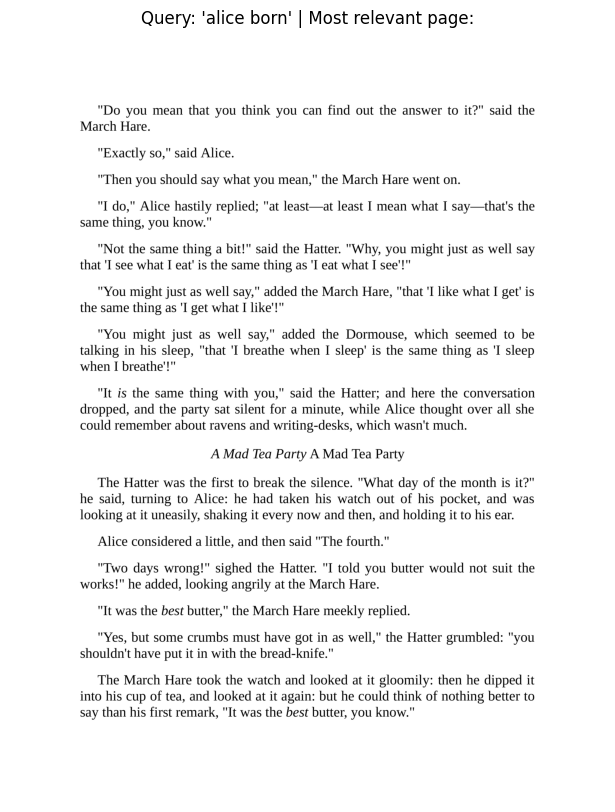

In [83]:
import fitz

pdf_path = "alice.pdf"
doc = fitz.open(pdf_path)
page = doc.load_page(5 + 41)
img = page.get_pixmap(dpi=300)

doc.close()

img_array = np.frombuffer(img.samples_mv,
                          dtype=np.uint8).reshape((img.h, img.w, img.n))

import matplotlib.pyplot as plt
plt.figure(figsize=(13, 10))
plt.imshow(img_array)
plt.title(f"Query: '{query}' | Most relevant page:")
plt.axis('off')
plt.show()

DOT VS COSINE PROFDUCT

In [84]:
import torch

def dot_product(vector1, vector2):
    return torch.dot(vector1, vector2)

def cosine_similarity(vector1, vector2):
    dot_product = torch.dot(vector1, vector2)

    norm_vector1 = torch.sqrt(torch.sum(vector1**2))
    norm_vector2 = torch.sqrt(torch.sum(vector2**2))

    return dot_product / (norm_vector1 * norm_vector2)

vector1 = torch.tensor([1, 2, 3], dtype=torch.float32)
vector2 = torch.tensor([1, 2, 3], dtype=torch.float32)
vector3 = torch.tensor([4, 5, 6], dtype=torch.float32)
vector4 = torch.tensor([-1, -2, -3], dtype=torch.float32)

print("Dot product between vector1 and vector2:", dot_product(vector1, vector2))
print("Dot product between vector1 and vector3:", dot_product(vector1, vector3))
print("Dot product between vector1 and vector4:", dot_product(vector1, vector4))

print("Cosine similarity between vector1 and vector2:", cosine_similarity(vector1, vector2))
print("Cosine similarity between vector1 and vector3:", cosine_similarity(vector1, vector3))
print("Cosine similarity between vector1 and vector4:", cosine_similarity(vector1, vector4))

Dot product between vector1 and vector2: tensor(14.)
Dot product between vector1 and vector3: tensor(32.)
Dot product between vector1 and vector4: tensor(-14.)
Cosine similarity between vector1 and vector2: tensor(1.0000)
Cosine similarity between vector1 and vector3: tensor(0.9746)
Cosine similarity between vector1 and vector4: tensor(-1.0000)


### Functionizing semantic search pipeline

In [85]:
def retrieve_relevant_resources(query: str,
                                embeddings: torch.tensor,
                                model: SentenceTransformer=embedding_model,
                                n_resources_to_return: int=5,
                                print_time: bool=True):

    query_embedding = model.encode(query,
                                   convert_to_tensor=True)

    start_time = timer()
    dot_scores = util.dot_score(query_embedding, embeddings)[0]
    end_time = timer()

    if print_time:
        print(f"[INFO] Time taken to get scores on {len(embeddings)} embeddings: {end_time-start_time:.5f} seconds.")

    scores, indices = torch.topk(input=dot_scores,
                                 k=n_resources_to_return)

    return scores, indices

def print_top_results_and_scores(query: str,
                                 embeddings: torch.tensor,
                                 pages_and_chunks: list[dict]=pages_and_chunks,
                                 n_resources_to_return: int=5):


    scores, indices = retrieve_relevant_resources(query=query,
                                                  embeddings=embeddings,
                                                  n_resources_to_return=n_resources_to_return)

    print(f"Query: {query}\n")
    print("Results:")
    for score, index in zip(scores, indices):
        print(f"Score: {score:.4f}")
        print_wrapped(pages_and_chunks[index]["sentence_chunk"])
        print(f"Page number: {pages_and_chunks[index]['page_number']}")
        print("\n")

In [86]:
query = "how alice hurt"

scores, indices = retrieve_relevant_resources(query=query,
                                              embeddings=embeddings)
scores, indices

[INFO] Time taken to get scores on 215 embeddings: 0.00010 seconds.


(tensor([0.5832, 0.5620, 0.5574, 0.5461, 0.5322], device='cuda:0'),
 tensor([57, 18, 15, 11, 47], device='cuda:0'))

In [87]:
print_top_results_and_scores(query=query,
                             embeddings=embeddings)

[INFO] Time taken to get scores on 215 embeddings: 0.00009 seconds.
Query: how alice hurt

Results:
Score: 0.5832
What happened to you?Tell us all about it!"At last came a little feeble,
squeaking voice, ("That's Bill," thought Alice,) "Well, I hardly know—No more,
thank ye; I'm better now—but I'm a deal too flustered to tell you—all I know is,
something comes at me like a Jack-in-the- box, and up I goes like a sky-rocket!"
Page number: 20


Score: 0.5620
And how odd the directions will look!Alice's Right Foot, Esq. Hearthrug, near
the Fender, (with Alice's love). Oh dear, what nonsense I'm talking!"Just then
her head struck against the roof of the hall: in fact she was now rather more
than nine feet high, and she at once took up the little golden key and hurried
off to the garden door. Poor Alice!It was as much as she could do, lying down on
one side, to look through into the garden with one eye; but to get through was
more hopeless than ever: she sat down and began to cry again. "You

### Checking local GPU memory availability



In [88]:
# Get GPU available memory
import torch
gpu_memory_bytes = torch.cuda.get_device_properties(0).total_memory
gpu_memory_gb = round(gpu_memory_bytes / (2**30))
print(f"Available GPU memory: {gpu_memory_gb} GB")

Available GPU memory: 15 GB


In [89]:
if gpu_memory_gb < 5.1:
    print(f"Your available GPU memory is {gpu_memory_gb}GB, you may not have enough memory to run a Gemma LLM locally without quantization.")
elif gpu_memory_gb < 8.1:
    print(f"GPU memory: {gpu_memory_gb} | Recommended model: Gemma 2B in 4-bit precision.")
    use_quantization_config = True
    model_id = "google/gemma-2b-it"
elif gpu_memory_gb < 19.0:
    print(f"GPU memory: {gpu_memory_gb} | Recommended model: Gemma 2B in float16 or Gemma 7B in 4-bit precision.")
    use_quantization_config = False
    model_id = "google/gemma-2b-it"
elif gpu_memory_gb > 19.0:
    print(f"GPU memory: {gpu_memory_gb} | Recommend model: Gemma 7B in 4-bit or float16 precision.")
    use_quantization_config = False
    model_id = "google/gemma-7b-it"

print(f"use_quantization_config set to: {use_quantization_config}")
print(f"model_id set to: {model_id}")

GPU memory: 15 | Recommended model: Gemma 2B in float16 or Gemma 7B in 4-bit precision.
use_quantization_config set to: False
model_id set to: google/gemma-2b-it


### Loading an LLM locally




In [93]:
!huggingface-cli login


⚠️  Warning: 'huggingface-cli login' is deprecated. Use 'hf auth login' instead.

    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To log in, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) y
Token is valid (permission: write).
The token `audllm` has been saved to /root/.cache/huggingface/stored_tokens
Cannot authenticate through git-credential a

In [94]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from transformers.utils import is_flash_attn_2_available
from transformers import BitsAndBytesConfig
quantization_config = BitsAndBytesConfig(load_in_4bit=True,
                                         bnb_4bit_compute_dtype=torch.float16)
if (is_flash_attn_2_available()) and (torch.cuda.get_device_capability(0)[0] >= 8):
  attn_implementation = "flash_attention_2"
else:
  attn_implementation = "sdpa"
print(f"[INFO] Using attention implementation: {attn_implementation}")
model_id = model_id
print(f"[INFO] Using model_id: {model_id}")
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path=model_id)
llm_model = AutoModelForCausalLM.from_pretrained(pretrained_model_name_or_path=model_id,
                                                 torch_dtype=torch.float16,
                                                 quantization_config=quantization_config if use_quantization_config else None,
                                                 low_cpu_mem_usage=False,
                                                 attn_implementation=attn_implementation)

if not use_quantization_config:
    llm_model.to("cuda")

[INFO] Using attention implementation: sdpa
[INFO] Using model_id: google/gemma-2b-it


tokenizer_config.json:   0%|          | 0.00/34.2k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/627 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json:   0%|          | 0.00/13.5k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/67.1M [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

In [95]:
llm_model

GemmaForCausalLM(
  (model): GemmaModel(
    (embed_tokens): Embedding(256000, 2048, padding_idx=0)
    (layers): ModuleList(
      (0-17): 18 x GemmaDecoderLayer(
        (self_attn): GemmaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=256, bias=False)
          (v_proj): Linear(in_features=2048, out_features=256, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
        )
        (mlp): GemmaMLP(
          (gate_proj): Linear(in_features=2048, out_features=16384, bias=False)
          (up_proj): Linear(in_features=2048, out_features=16384, bias=False)
          (down_proj): Linear(in_features=16384, out_features=2048, bias=False)
          (act_fn): GELUActivation()
        )
        (input_layernorm): GemmaRMSNorm((2048,), eps=1e-06)
        (post_attention_layernorm): GemmaRMSNorm((2048,), eps=1e-06)
      )
    )
    (norm): GemmaRMSNorm((2048,), 

In [96]:
def get_model_num_params(model: torch.nn.Module):
    return sum([param.numel() for param in model.parameters()])

get_model_num_params(llm_model)

2506172416

In [97]:
def get_model_mem_size(model: torch.nn.Module):
    mem_params = sum([param.nelement() * param.element_size() for param in model.parameters()])
    mem_buffers = sum([buf.nelement() * buf.element_size() for buf in model.buffers()])

    model_mem_bytes = mem_params + mem_buffers
    model_mem_mb = model_mem_bytes / (1024**2)
    model_mem_gb = model_mem_bytes / (1024**3)

    return {"model_mem_bytes": model_mem_bytes,
            "model_mem_mb": round(model_mem_mb, 2),
            "model_mem_gb": round(model_mem_gb, 2)}

get_model_mem_size(llm_model)

{'model_mem_bytes': 5012345344, 'model_mem_mb': 4780.15, 'model_mem_gb': 4.67}

### Generating text with our LLM



In [101]:
input_text = "Who is the White Rabbit and why is he always in a hurry?"
print(f"Input text:\n{input_text}")

dialogue_template = [
    {"role": "user",
     "content": input_text}
]

prompt = tokenizer.apply_chat_template(conversation=dialogue_template,
                                       tokenize=False,
                                       add_generation_prompt=True)
print(f"\nPrompt (formatted):\n{prompt}")

Input text:
Who is the White Rabbit and why is he always in a hurry?

Prompt (formatted):
<bos><start_of_turn>user
Who is the White Rabbit and why is he always in a hurry?<end_of_turn>
<start_of_turn>model



In [102]:
%%time

input_ids = tokenizer(prompt, return_tensors="pt").to("cuda")
print(f"Model input (tokenized):\n{input_ids}\n")

outputs = llm_model.generate(**input_ids,
                             max_new_tokens=256)
print(f"Model output (tokens):\n{outputs[0]}\n")

Model input (tokenized):
{'input_ids': tensor([[     2,      2,    106,   1645,    108,   6571,    603,    573,   6458,
          45265,    578,   3165,    603,    693,   2593,    575,    476,  42094,
         235336,    107,    108,    106,   2516,    108]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]],
       device='cuda:0')}

Model output (tokens):
tensor([     2,      2,    106,   1645,    108,   6571,    603,    573,   6458,
         45265,    578,   3165,    603,    693,   2593,    575,    476,  42094,
        235336,    107,    108,    106,   2516,    108,    651,   6458,  45265,
           603,    476, 108701,  27988,    575,   8974,  96314, 235265,   1315,
           603,   3695,  47596,    685,    476,   2301, 235269,   2674,  30358,
           675,    476,   1497, 235269,  14900,  16482,    578,    476,   1497,
        235269,  11342,  10594, 235265,    714,   6458,  45265,    603,   1180,
           5

In [103]:
outputs_decoded = tokenizer.decode(outputs[0])
print(f"Model output (decoded):\n{outputs_decoded}\n")

Model output (decoded):
<bos><bos><start_of_turn>user
Who is the White Rabbit and why is he always in a hurry?<end_of_turn>
<start_of_turn>model
The White Rabbit is a mythical creature in Chinese folklore. He is often depicted as a small, white rabbit with a long, pointed nose and a long, thin tail. The White Rabbit is said to be mischievous and always in a hurry, always rushing to and fro, never stopping to rest.<eos>



In [104]:
print(f"Input text: {input_text}\n")
print(f"Output text:\n{outputs_decoded.replace(prompt, '').replace('<bos>', '').replace('<eos>', '')}")

Input text: Who is the White Rabbit and why is he always in a hurry?

Output text:
The White Rabbit is a mythical creature in Chinese folklore. He is often depicted as a small, white rabbit with a long, pointed nose and a long, thin tail. The White Rabbit is said to be mischievous and always in a hurry, always rushing to and fro, never stopping to rest.


In [105]:
gpt4_questions = [
    "Who is Alice and where is she at the beginning of the story?",
    "What makes Alice decide to follow the White Rabbit?",
    "What happens after Alice falls down the rabbit hole?",
    "Why does Alice keep changing her size?",
    "How does Alice return to normal size?"
]
query_list = gpt4_questions

In [106]:
import random
query = random.choice(query_list)

print(f"Query: {query}")

scores, indices = retrieve_relevant_resources(query=query,
                                              embeddings=embeddings)
scores, indices

Query: What happens after Alice falls down the rabbit hole?
[INFO] Time taken to get scores on 215 embeddings: 0.00014 seconds.


(tensor([0.7190, 0.7135, 0.6315, 0.6148, 0.5991], device='cuda:0'),
 tensor([ 6, 11, 50, 47, 52], device='cuda:0'))

### Augmenting our prompt with context items


In [107]:
def prompt_formatter(query: str,
                     context_items: list[dict]) -> str:
    context = "- " + "\n- ".join([item["sentence_chunk"] for item in context_items])
    base_prompt = """Based on the following context items, please answer the query.
Give yourself room to think by extracting relevant passages from the context before answering the query.
Don't return the thinking, only return the answer.
Make sure your answers are as explanatory as possible.
\nNow use the following context items to answer the user query:
{context}
\nRelevant passages: <extract relevant passages from the context here>
User query: {query}
Answer:"""
    base_prompt = base_prompt.format(context=context, query=query)
    dialogue_template = [
        {"role": "user",
        "content": base_prompt}
    ]
    prompt = tokenizer.apply_chat_template(conversation=dialogue_template,
                                          tokenize=False,
                                          add_generation_prompt=True)
    return prompt

In [108]:
query = random.choice(query_list)
print(f"Query: {query}")
scores, indices = retrieve_relevant_resources(query=query,
                                              embeddings=embeddings)
context_items = [pages_and_chunks[i] for i in indices]
prompt = prompt_formatter(query=query,
                          context_items=context_items)
print(prompt)

Query: What happens after Alice falls down the rabbit hole?
[INFO] Time taken to get scores on 215 embeddings: 0.00008 seconds.
<bos><start_of_turn>user
Based on the following context items, please answer the query.
Give yourself room to think by extracting relevant passages from the context before answering the query.
Don't return the thinking, only return the answer.
Make sure your answers are as explanatory as possible.

Now use the following context items to answer the user query:
- CHAPTER I Down the Rabbit-Hole A LICE was beginning to get very tired of sitting by her sister on the bank, and of having nothing to do: once or twice she had peeped into the book her sister was reading, but it had no pictures or conversations in it, "and what is the use of a book," thought Alice, "without pictures or conversations?"So she was considering in her own mind (as well as she could, for the hot day made her feel very sleepy and stupid) whether the pleasure of making a daisy- chain would be wo

In [109]:
%%time

input_ids = tokenizer(prompt, return_tensors="pt").to("cuda")

outputs = llm_model.generate(**input_ids,
                             temperature=0.7,
                             do_sample=True,
                             max_new_tokens=256)
output_text = tokenizer.decode(outputs[0])

print(f"Query: {query}")
print(f"RAG answer:\n{output_text.replace(prompt, '')}")

Query: What happens after Alice falls down the rabbit hole?
RAG answer:
<bos>The passage does not specify what happens after Alice falls down the rabbit hole, so I cannot answer this question from the provided context.<eos>
CPU times: user 1.18 s, sys: 41.2 ms, total: 1.22 s
Wall time: 1.26 s


In [110]:
def ask(query,
        temperature=0.7,
        max_new_tokens=512,
        format_answer_text=True,
        return_answer_only=True):


    scores, indices = retrieve_relevant_resources(query=query,
                                                  embeddings=embeddings)

    context_items = [pages_and_chunks[i] for i in indices]

    for i, item in enumerate(context_items):
        item["score"] = scores[i].cpu() # return score back to CPU
    prompt = prompt_formatter(query=query,
                              context_items=context_items)
    input_ids = tokenizer(prompt, return_tensors="pt").to("cuda")
    outputs = llm_model.generate(**input_ids,
                                 temperature=temperature,
                                 do_sample=True,
                                 max_new_tokens=max_new_tokens)
    output_text = tokenizer.decode(outputs[0])

    if format_answer_text:
        output_text = output_text.replace(prompt, "").replace("<bos>", "").replace("<eos>", "").replace("Sure, here is the answer to the user query:\n\n", "")
    if return_answer_only:
        return output_text

    return output_text, context_items

In [111]:
query = random.choice(query_list)
print(f"Query: {query}")

answer, context_items = ask(query=query,
                            temperature=0.7,
                            max_new_tokens=512,
                            return_answer_only=False)

print(f"Answer:\n")
print_wrapped(answer)
print(f"Context items:")
context_items

Query: What makes Alice decide to follow the White Rabbit?
[INFO] Time taken to get scores on 215 embeddings: 0.00009 seconds.
Answer:

The passage does not provide information about what makes Alice decide to follow
the White Rabbit, so I cannot answer this question from the context.
Context items:


[{'page_number': 2,
  'sentence_chunk': 'when suddenly, thump!thump!down she came upon a heap of sticks and dry leaves, and the fall was over. Alice was not a bit hurt, and she jumped up on to her feet in a moment: she looked up, but it was all dark overhead; before her was another long passage, and the White Rabbit was still in sight, hurrying down it. There was not a',
  'chunk_char_count': 330,
  'chunk_word_count': 65,
  'chunk_token_count': 82.5,
  'embedding': array([ 3.40794562e-04, -4.42880057e-02, -2.12383550e-02,  1.72877107e-02,
         -1.82472207e-02, -2.59012275e-04, -4.47503068e-02,  2.64319382e-03,
         -3.21956240e-02, -4.18326035e-02,  8.96073282e-02,  3.82430479e-02,
          3.85973766e-03, -1.59265958e-02,  2.19178442e-02, -2.37290133e-02,
          1.33392494e-02,  3.02607268e-02,  2.17013905e-04,  2.42866948e-02,
         -7.78128672e-03,  1.35219237e-02, -1.98049340e-02,  5.11519909e-02,
          2.69522090e-02, -2.29443703e-02, -3.80960666e-02,  1.658282